## Setup & Imports

In [20]:
import os
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import time
import json
import glob
from tqdm import tqdm

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette(None)

import albumentations as A
from albumentations.pytorch import ToTensorV2

# Config
DATASET_DIR = "./data/train"
OUTPUT_DIR = "./eda_results"
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
GRID_SIZE = 7
NUM_CLASSES = 12
NUM_BBOXES = 2

os.makedirs(OUTPUT_DIR, exist_ok=True)

print(f"Device: {DEVICE}")

Device: cuda


## Loss Function & Metrics

In [21]:
class YOLOLoss(nn.Module):
    """
    YOLO Loss combining:
    - Localization loss (MSE for bbox with sqrt weighting for w,h)
    - Confidence loss (MSE for objectness)
    - Classification loss (Cross-entropy)
    """
    def __init__(self, num_classes=12, grid_size=7, num_bboxes=2, lambda_coord=5.0, lambda_noobj=0.5):
        super().__init__()
        self.num_classes = num_classes
        self.grid_size = grid_size
        self.num_bboxes = num_bboxes
        self.lambda_coord = lambda_coord
        self.lambda_noobj = lambda_noobj
        self.eps = 1e-6
    
    def forward(self, predictions, targets):
        batch_size = predictions.size(0)
        obj_mask = targets[:, :, :, 4] > 0.5
        noobj_mask = ~obj_mask
        
        total_loss = 0.0
        
        # Process each bounding box
        for box_idx in range(self.num_bboxes):
            box_start = box_idx * 5
            
            # Localization loss
            pred_xy = torch.sigmoid(predictions[:, :, :, box_start:box_start+2])
            targ_xy = targets[:, :, :, box_start:box_start+2].clamp(0, 1)
            pred_wh = torch.sigmoid(predictions[:, :, :, box_start+2:box_start+4])
            targ_wh = targets[:, :, :, box_start+2:box_start+4].clamp(self.eps, 1)
            
            xy_loss = (obj_mask.unsqueeze(-1).float() * (pred_xy - targ_xy)**2).sum()
            wh_loss = (obj_mask.unsqueeze(-1).float() * 
                      (torch.sqrt(pred_wh + self.eps) - torch.sqrt(targ_wh + self.eps))**2).sum()
            
            total_loss += self.lambda_coord * (xy_loss + wh_loss)
            
            # Confidence loss
            pred_conf = torch.sigmoid(predictions[:, :, :, box_start+4])
            targ_conf = targets[:, :, :, box_start+4]
            conf_obj = (obj_mask.float() * (pred_conf - targ_conf)**2).sum()
            conf_noobj = self.lambda_noobj * (noobj_mask.float() * (pred_conf - 0)**2).sum()
            total_loss += conf_obj + conf_noobj
        
        # Classification loss
        pred_class = predictions[:, :, :, self.num_bboxes*5:]
        targ_class = targets[:, :, :, self.num_bboxes*5:]
        if obj_mask.any():
            pred_class_obj = pred_class[obj_mask]
            targ_class_obj = targ_class[obj_mask]
            targ_class_idx = torch.argmax(targ_class_obj, dim=1)
            cls_loss = F.cross_entropy(pred_class_obj, targ_class_idx, reduction='sum')
            total_loss += cls_loss
        
        return total_loss / batch_size


def compute_iou(box1, box2):
    """Compute IoU between two boxes [x_center, y_center, w, h] (normalized)"""
    if box1[2] <= 0 or box1[3] <= 0 or box2[2] <= 0 or box2[3] <= 0:
        return 0.0
    
    x1_min = max(0, box1[0] - box1[2]/2)
    y1_min = max(0, box1[1] - box1[3]/2)
    x1_max = min(1, box1[0] + box1[2]/2)
    y1_max = min(1, box1[1] + box1[3]/2)
    
    x2_min = max(0, box2[0] - box2[2]/2)
    y2_min = max(0, box2[1] - box2[3]/2)
    x2_max = min(1, box2[0] + box2[2]/2)
    y2_max = min(1, box2[1] + box2[3]/2)
    
    inter_xmin = max(x1_min, x2_min)
    inter_ymin = max(y1_min, y2_min)
    inter_xmax = min(x1_max, x2_max)
    inter_ymax = min(y1_max, y2_max)
    
    if inter_xmax < inter_xmin or inter_ymax < inter_ymin:
        return 0.0
    
    inter_area = (inter_xmax - inter_xmin) * (inter_ymax - inter_ymin)
    box1_area = box1[2] * box1[3]
    box2_area = box2[2] * box2[3]
    union_area = box1_area + box2_area - inter_area
    
    return inter_area / union_area if union_area > 0 else 0.0


def compute_mAP(predictions, targets, iou_threshold=0.5):
    """Compute mAP using IoU-based matching"""
    if len(predictions) == 0 or len(targets) == 0:
        return 0.0
    
    sorted_preds = sorted(predictions, key=lambda x: x[1], reverse=True)
    tp, fp, fn = 0, 0, len(targets)
    matched_targets = set()
    
    for pred_class, pred_conf, pred_box in sorted_preds:
        best_iou = 0
        best_target_idx = -1
        
        for target_idx, (target_class, target_box) in enumerate(targets):
            if target_idx in matched_targets or target_class != pred_class:
                continue
            iou = compute_iou(pred_box, target_box)
            if iou > best_iou:
                best_iou = iou
                best_target_idx = target_idx
        
        if best_iou >= iou_threshold and best_target_idx >= 0:
            tp += 1
            matched_targets.add(best_target_idx)
            fn -= 1
        else:
            fp += 1
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    recall = tp / (tp + fn + 1e-6)
    return 2 * (precision * recall) / (precision + recall + 1e-6)

print("Loss function and metrics defined")

Loss function and metrics defined


## Data Preprocessing

In [22]:
def get_transforms_yolo(split='train'):
    """Get preprocessing transforms for YOLO (448x448)"""
    if split == 'train':
        return A.Compose([
            A.Resize(448, 448),
            A.HorizontalFlip(p=0.5),
            A.RandomBrightnessContrast(p=0.2),
            A.Rotate(limit=15, p=0.2),
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ToTensorV2()
        ])
    else:
        return A.Compose([
            A.Resize(448, 448),
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ToTensorV2()
        ])


class CattleDetectionDataset(Dataset):
    """Custom dataset for object detection"""
    def __init__(self, dataset_dir, transform=None, grid_size=7, num_bboxes=2, num_classes=12):
        self.transform = transform
        self.grid_size = grid_size
        self.num_bboxes = num_bboxes
        self.num_classes = num_classes
        
        self.images_dir = os.path.join(dataset_dir, "images")
        self.labels_dir = os.path.join(dataset_dir, "labels")
        self.image_files = []
        self.label_files = []
        
        for img_file in os.listdir(self.images_dir):
            if img_file.lower().endswith('.jpg'):
                img_path = os.path.join(self.images_dir, img_file)
                label_file = os.path.splitext(img_file)[0] + '.txt'
                label_path = os.path.join(self.labels_dir, label_file)
                if os.path.exists(label_path):
                    self.image_files.append(img_path)
                    self.label_files.append(label_path)
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        image = Image.open(self.image_files[idx]).convert('RGB')
        image = np.array(image)
        
        boxes, classes = [], []
        with open(self.label_files[idx]) as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) < 5:
                    continue
                cls = int(parts[0])
                x, y, w, h = map(float, parts[1:5])
                x, y = max(0, min(1, x)), max(0, min(1, y))
                w, h = max(0, min(1, w)), max(0, min(1, h))
                if w > 0 and h > 0:
                    boxes.append([x, y, w, h])
                    classes.append(cls)
        
        if self.transform:
            image = self.transform(image=image)['image']
        
        target = torch.zeros(self.grid_size, self.grid_size, self.num_bboxes * 5 + self.num_classes)
        for box, cls in zip(boxes, classes):
            x, y, w, h = box
            grid_x = min(max(0, int(x * self.grid_size)), self.grid_size - 1)
            grid_y = min(max(0, int(y * self.grid_size)), self.grid_size - 1)
            if target[grid_y, grid_x, 4] == 0:
                target[grid_y, grid_x, 0:4] = torch.tensor([x, y, w, h], dtype=torch.float32)
                target[grid_y, grid_x, 4] = 1.0
                target[grid_y, grid_x, 5 + cls] = 1.0
        
        return image, target


# Load dataset
print("Loading dataset...")
transform = get_transforms_yolo(split='train')
dataset = CattleDetectionDataset(DATASET_DIR, transform=transform, grid_size=GRID_SIZE)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

print(f"Dataset loaded: {len(dataset)} images total")
print(f"  - Train: {len(train_dataset)}")
print(f"  - Validation: {len(val_dataset)}")

Loading dataset...
Dataset loaded: 1747 images total
  - Train: 1397
  - Validation: 350


## Model Architectures

In [23]:
class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)


class AlexNetDetector(nn.Module):
    """AlexNet with custom detection head"""
    def __init__(self, num_classes=12, grid_size=7, num_bboxes=2):
        super().__init__()
        # Use AlexNet features (first 5 conv layers)
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((grid_size, grid_size))
        self.detector = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.LeakyReLU(0.1),
            nn.Dropout2d(0.3),
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.LeakyReLU(0.1),
            nn.Conv2d(256, num_bboxes * 5 + num_classes, kernel_size=1)
        )
        self.grid_size = grid_size
    
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = self.detector(x)
        return x.permute(0, 2, 3, 1)


class YOLOv1(nn.Module):
    """Strict YOLOv1 implementation as in the original paper"""
    def __init__(self, num_classes=20, grid_size=7, num_bboxes=2):
        super().__init__()
        self.feature_size = grid_size
        self.num_bboxes = num_bboxes
        self.num_classes = num_classes
        
        # Feature extraction (first 20 conv layers)
        self.features = nn.Sequential(
            # Layer 1-2
            nn.Conv2d(3, 64, 7, stride=2, padding=3), nn.LeakyReLU(0.1),
            nn.MaxPool2d(2, 2),
            
            # Layer 3-4
            nn.Conv2d(64, 192, 3, padding=1), nn.LeakyReLU(0.1),
            nn.MaxPool2d(2, 2),
            
            # Layer 5-6
            nn.Conv2d(192, 128, 1), nn.LeakyReLU(0.1),
            nn.Conv2d(128, 256, 3, padding=1), nn.LeakyReLU(0.1),
            
            # Layer 7-8
            nn.Conv2d(256, 256, 1), nn.LeakyReLU(0.1),
            nn.Conv2d(256, 512, 3, padding=1), nn.LeakyReLU(0.1),
            nn.MaxPool2d(2, 2),
            
            # Layer 9-16 (4 repetitions of 1x1 and 3x3)
            *self._make_conv_block(512, 256, 512, 4),
            
            # Layer 17-20
            nn.Conv2d(512, 512, 1), nn.LeakyReLU(0.1),
            nn.Conv2d(512, 1024, 3, padding=1), nn.LeakyReLU(0.1),
            nn.MaxPool2d(2, 2),
            
            # Layer 21-24 (2 repetitions of 1x1 and 3x3)
            *self._make_conv_block(1024, 512, 1024, 2),
        )
        
        # Detection layers (last 4 conv layers + 2 FC layers)
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1024, 1024, 3, padding=1), nn.LeakyReLU(0.1),
            nn.Conv2d(1024, 1024, 3, stride=2, padding=1), nn.LeakyReLU(0.1),
            nn.Conv2d(1024, 1024, 3, padding=1), nn.LeakyReLU(0.1),
            nn.Conv2d(1024, 1024, 3, padding=1), nn.LeakyReLU(0.1),
        )
        
        self.fc_layers = nn.Sequential(
            Flatten(),
            nn.Linear(7 * 7 * 1024, 4096), nn.LeakyReLU(0.1),
            nn.Dropout(0.5),
            nn.Linear(4096, grid_size * grid_size * (5 * num_bboxes + num_classes))
        )
    
    def _make_conv_block(self, in_channels, mid_channels, out_channels, repetitions):
        layers = []
        for _ in range(repetitions):
            layers.extend([
                nn.Conv2d(in_channels, mid_channels, 1), nn.LeakyReLU(0.1),
                nn.Conv2d(mid_channels, out_channels, 3, padding=1), nn.LeakyReLU(0.1)
            ])
            in_channels = out_channels
        return layers
    
    def forward(self, x):
        S, B, C = self.feature_size, self.num_bboxes, self.num_classes
        x = self.features(x)
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x.view(-1, S, S, 5 * B + C)


class YOLOv1Detector(nn.Module):
    """YOLOv1 with the exact original architecture"""
    def __init__(self, num_classes=12, grid_size=7, num_bboxes=2):
        super().__init__()
        # Use the full YOLOv1 architecture
        self.yolo = YOLOv1(num_classes=num_classes, grid_size=grid_size, num_bboxes=num_bboxes)
    
    def forward(self, x):
        return self.yolo(x)


# Create models
alexnet = AlexNetDetector(num_classes=NUM_CLASSES).to(DEVICE)
yolo = YOLOv1Detector(num_classes=NUM_CLASSES).to(DEVICE)

print(f"✓ Models created")
print(f"  - AlexNet parameters: {sum(p.numel() for p in alexnet.parameters()):,}")
print(f"  - YOLOv1 parameters: {sum(p.numel() for p in yolo.parameters()):,}")

✓ Models created
  - AlexNet parameters: 4,835,414
  - YOLOv1 parameters: 270,097,526


## Training Functions

In [24]:
def train_epoch(model, dataloader, loss_fn, optimizer, device):
    """Train one epoch"""
    model.train()
    total_loss = 0.0
    for images, targets in tqdm(dataloader, desc="  Training", leave=False):
        images, targets = images.to(device), targets.to(device)
        optimizer.zero_grad()
        predictions = model(images)
        loss = loss_fn(predictions, targets)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)


def validate(model, dataloader, loss_fn, device, compute_f1=False):
    """Validate model"""
    model.eval()
    total_loss = 0.0
    all_detections, all_ground_truths = [], []
    
    with torch.no_grad():
        for images, targets in tqdm(dataloader, desc="  Validating", leave=False):
            images, targets = images.to(device), targets.to(device)
            predictions = model(images)
            loss = loss_fn(predictions, targets)
            total_loss += loss.item()
            
            if compute_f1:
                for b in range(predictions.size(0)):
                    for i in range(GRID_SIZE):
                        for j in range(GRID_SIZE):
                            conf = torch.sigmoid(predictions[b, i, j, 4]).item()
                            if conf > 0.3:
                                x = torch.clamp(predictions[b, i, j, 0], 0, 1).item()
                                y = torch.clamp(predictions[b, i, j, 1], 0, 1).item()
                                w = torch.clamp(predictions[b, i, j, 2], 0, 1).item()
                                h = torch.clamp(predictions[b, i, j, 3], 0, 1).item()
                                cls_probs = torch.softmax(predictions[b, i, j, NUM_BBOXES*5:], dim=0)
                                cls = torch.argmax(cls_probs).item()
                                all_detections.append((cls, conf, [x, y, w, h]))
                    
                    for i in range(GRID_SIZE):
                        for j in range(GRID_SIZE):
                            if targets[b, i, j, 4] > 0.5:
                                x, y, w, h = targets[b, i, j, :4].tolist()
                                cls_probs = targets[b, i, j, NUM_BBOXES*5:]
                                cls = torch.argmax(cls_probs).item() if cls_probs.sum() > 0 else 0
                                all_ground_truths.append((cls, [x, y, w, h]))
    
    f1 = compute_mAP(all_detections, all_ground_truths) if compute_f1 else 0.0
    return total_loss / len(dataloader), f1


def train_model(model, train_loader, val_loader, config, loss_fn, device, model_name='Model'):
    """Full training loop"""
    optimizer = torch.optim.AdamW(model.parameters(), 
                                   lr=config['learning_rate'], 
                                   weight_decay=config['weight_decay'])
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, T_max=config['epochs'],
        eta_min=config['learning_rate'] * 0.01
    )
    
    train_losses, val_losses, val_f1s = [], [], []
    best_val_loss = float('inf')
    patience = 10
    patience_counter = 0
    best_state = None
    
    for epoch in tqdm(range(config['epochs']), desc=f"{model_name} Training"):
        train_loss = train_epoch(model, train_loader, loss_fn, optimizer, device)
        compute_f1 = (epoch % 3 == 0) or (epoch >= config['epochs'] - 5)
        val_loss, f1 = validate(model, val_loader, loss_fn, device, compute_f1=compute_f1)
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        val_f1s.append(f1)
        
        if epoch >= config['warmup_epochs']:
            scheduler.step()
        
        if val_loss < best_val_loss * 0.995:
            best_val_loss = val_loss
            patience_counter = 0
            best_state = model.state_dict().copy()
        else:
            patience_counter += 1
        
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break
    
    if best_state is not None:
        model.load_state_dict(best_state)
    
    return {
        'train_losses': train_losses, 
        'val_losses': val_losses, 
        'val_maps': val_f1s,
        'best_val_loss': best_val_loss, 
        'best_map': max(val_f1s) if val_f1s else 0.0
    }

print("✓ Training functions defined")

✓ Training functions defined


## Create Data Loaders

In [25]:
batch_size = 16

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)

print(f"✓ Data loaders created")
print(f"  - Train batches: {len(train_loader)}")
print(f"  - Val batches: {len(val_loader)}")

✓ Data loaders created
  - Train batches: 88
  - Val batches: 22


## Training Configuration

In [26]:
config = {
    'learning_rate': 0.0001,
    'batch_size': batch_size,
    'weight_decay': 1e-4,
    'lambda_coord': 5.0,
    'epochs': 30,
    'warmup_epochs': 3,
}

loss_fn = YOLOLoss(num_classes=NUM_CLASSES, lambda_coord=config['lambda_coord']).to(DEVICE)

print("Training Configuration:")
for key, val in config.items():
    print(f"  {key}: {val}")

Training Configuration:
  learning_rate: 0.0001
  batch_size: 16
  weight_decay: 0.0001
  lambda_coord: 5.0
  epochs: 30
  warmup_epochs: 3


## Train AlexNet

In [27]:

print("TRAINING ALEXNET")

alexnet = AlexNetDetector(num_classes=NUM_CLASSES).to(DEVICE)
history_alex = train_model(alexnet, train_loader, val_loader, config, loss_fn, DEVICE, 'AlexNet')
torch.save(alexnet.state_dict(), os.path.join(OUTPUT_DIR, 'alexnet_best_model.pt'))

print(f"\n✓ AlexNet Training Complete!")
print(f"  Best Validation Loss: {history_alex['best_val_loss']:.4f}")
print(f"  Best mAP: {history_alex['best_map']:.4f}")
print(f"  Model saved to: {os.path.join(OUTPUT_DIR, 'alexnet_best_model.pt')}")

TRAINING ALEXNET


AlexNet Training: 100%|██████████| 30/30 [08:16<00:00, 16.56s/it]




✓ AlexNet Training Complete!
  Best Validation Loss: 4.8465
  Best mAP: 0.0337
  Model saved to: ./eda_results\alexnet_best_model.pt


## Train YOLOv1

In [28]:

print("TRAINING YOLO")

yolo = YOLOv1Detector(num_classes=NUM_CLASSES).to(DEVICE)
history_yolo = train_model(yolo, train_loader, val_loader, config, loss_fn, DEVICE, 'YOLOv1')
torch.save(yolo.state_dict(), os.path.join(OUTPUT_DIR, 'yolo_best_model.pt'))

print(f"\n✓ YOLOv1 Training Complete!")
print(f"  Best Validation Loss: {history_yolo['best_val_loss']:.4f}")
print(f"  Best mAP: {history_yolo['best_map']:.4f}")
print(f"  Model saved to: {os.path.join(OUTPUT_DIR, 'yolo_best_model.pt')}")

TRAINING YOLO


YOLOv1 Training:  50%|█████     | 15/30 [11:26<11:26, 45.75s/it]

Early stopping at epoch 16



✓ YOLOv1 Training Complete!
  Best Validation Loss: 8.8743
  Best mAP: 0.0000
  Model saved to: ./eda_results\yolo_best_model.pt


## Results Visualization

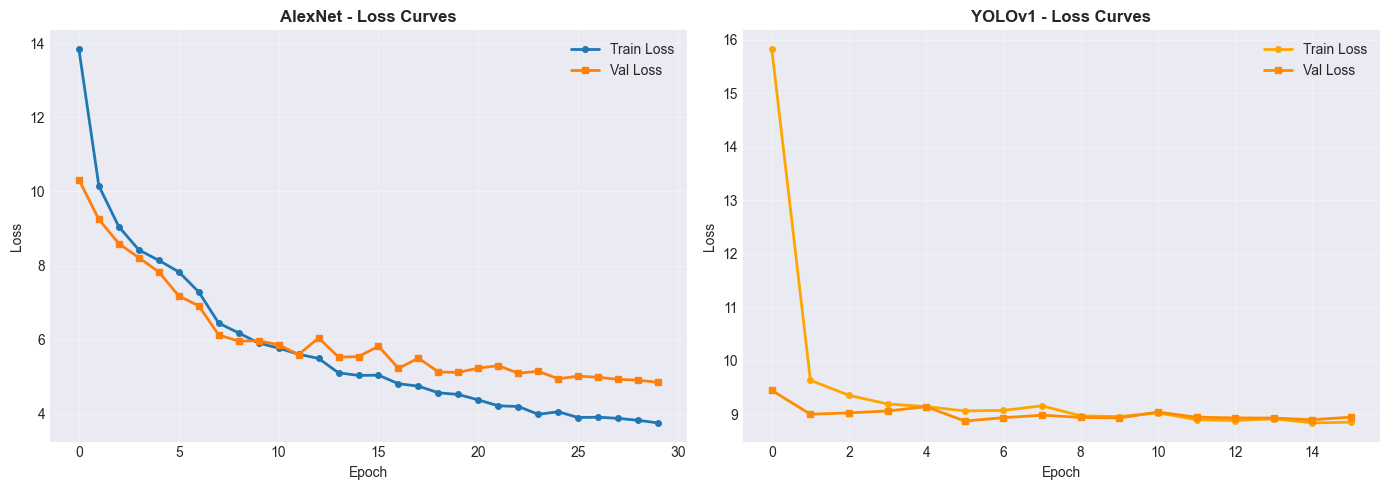

Saved: loss_curves.png


In [29]:
# Loss curves comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# AlexNet
axes[0].plot(history_alex['train_losses'], label='Train Loss', linewidth=2, marker='o', markersize=4)
axes[0].plot(history_alex['val_losses'], label='Val Loss', linewidth=2, marker='s', markersize=4)
axes[0].set_title('AlexNet - Loss Curves', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# YOLOv1
axes[1].plot(history_yolo['train_losses'], label='Train Loss', linewidth=2, marker='o', markersize=4, color='orange')
axes[1].plot(history_yolo['val_losses'], label='Val Loss', linewidth=2, marker='s', markersize=4, color='darkorange')
axes[1].set_title('YOLOv1 - Loss Curves', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'loss_curves.png'), dpi=100, bbox_inches='tight')
plt.show()
print("Saved: loss_curves.png")

## mAP Curves

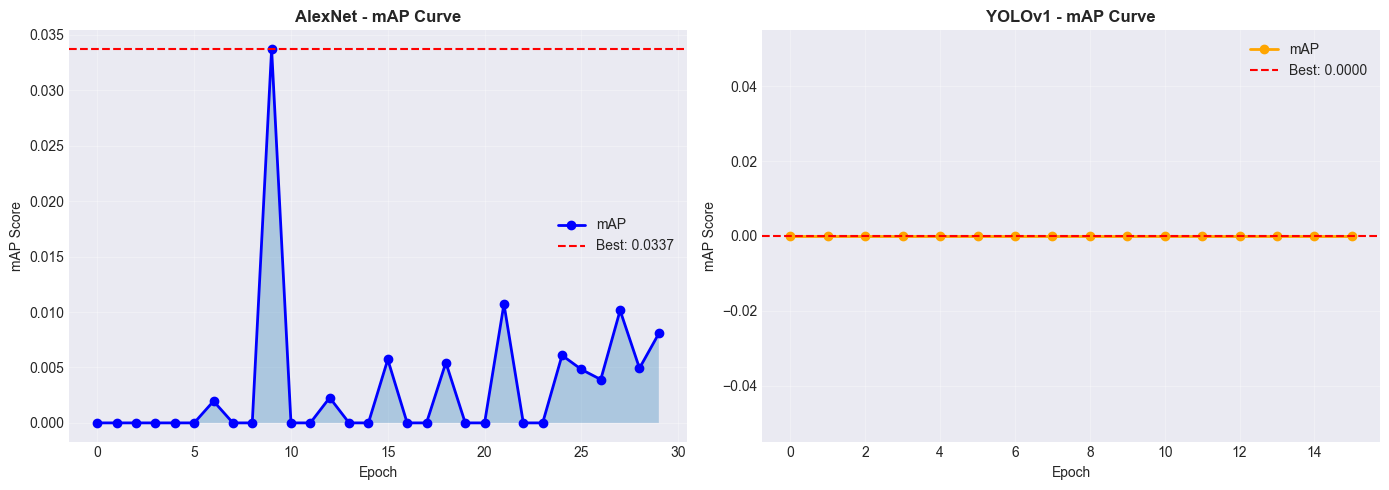

Saved: mAP_curves.png


In [30]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# AlexNet mAP
axes[0].plot(history_alex['val_maps'], label='mAP', linewidth=2, marker='o', color='blue')
axes[0].fill_between(range(len(history_alex['val_maps'])), history_alex['val_maps'], alpha=0.3)
axes[0].set_title('AlexNet - mAP Curve', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('mAP Score')
axes[0].axhline(y=history_alex['best_map'], color='r', linestyle='--', label=f'Best: {history_alex["best_map"]:.4f}')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# YOLOv1 mAP
axes[1].plot(history_yolo['val_maps'], label='mAP', linewidth=2, marker='o', color='orange')
axes[1].fill_between(range(len(history_yolo['val_maps'])), history_yolo['val_maps'], alpha=0.3, color='orange')
axes[1].set_title('YOLOv1 - mAP Curve', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('mAP Score')
axes[1].axhline(y=history_yolo['best_map'], color='r', linestyle='--', label=f'Best: {history_yolo["best_map"]:.4f}')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'mAP_curves.png'), dpi=100, bbox_inches='tight')
plt.show()
print("Saved: mAP_curves.png")

## Model Comparison


MODEL PERFORMANCE COMPARISON
          Metric   AlexNet      YOLOv1
   Best Val Loss    4.8465      8.8743
        Best mAP    0.0337      0.0000
Final Train Loss    3.7516      8.8533
  Final Val Loss    4.8465      8.9472
      Parameters 4,835,414 270,097,526


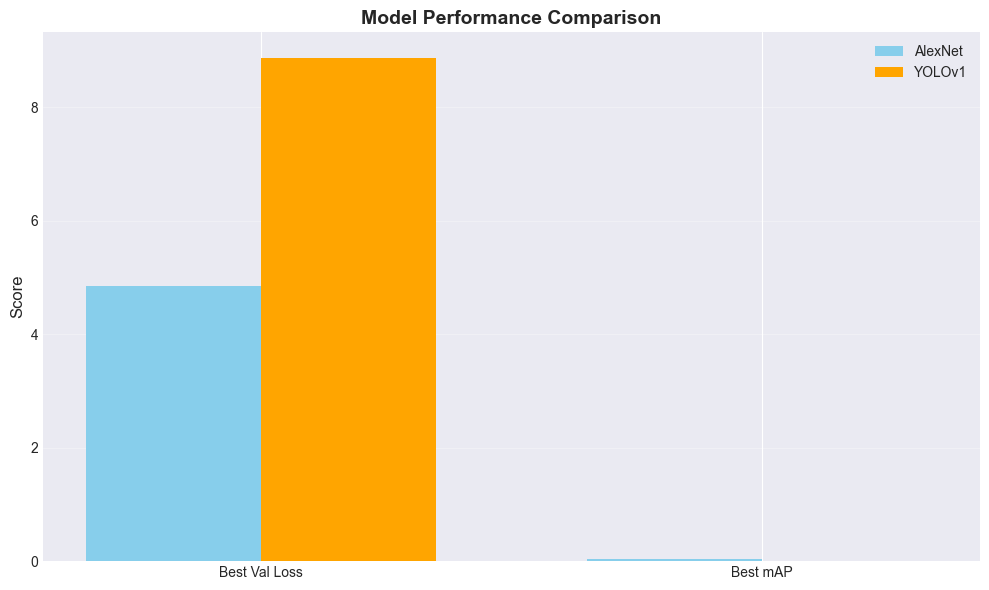


Saved: model_comparison.png


In [31]:
# Performance comparison table
comparison_data = {
    'Metric': ['Best Val Loss', 'Best mAP', 'Final Train Loss', 'Final Val Loss', 'Parameters'],
    'AlexNet': [
        f"{history_alex['best_val_loss']:.4f}",
        f"{history_alex['best_map']:.4f}",
        f"{history_alex['train_losses'][-1]:.4f}",
        f"{history_alex['val_losses'][-1]:.4f}",
        f"{sum(p.numel() for p in alexnet.parameters()):,}"
    ],
    'YOLOv1': [
        f"{history_yolo['best_val_loss']:.4f}",
        f"{history_yolo['best_map']:.4f}",
        f"{history_yolo['train_losses'][-1]:.4f}",
        f"{history_yolo['val_losses'][-1]:.4f}",
        f"{sum(p.numel() for p in yolo.parameters()):,}"
    ]
}

comparison_df = pd.DataFrame(comparison_data)
print("\n" + "="*70)
print("MODEL PERFORMANCE COMPARISON")
print("="*70)
print(comparison_df.to_string(index=False))

# Visualize comparison
fig, ax = plt.subplots(figsize=(10, 6))
metrics = ['Best Val Loss', 'Best mAP']
alexnet_vals = [history_alex['best_val_loss'], history_alex['best_map']]
yolo_vals = [history_yolo['best_val_loss'], history_yolo['best_map']]

x = np.arange(len(metrics))
width = 0.35

bars1 = ax.bar(x - width/2, alexnet_vals, width, label='AlexNet', color='skyblue')
bars2 = ax.bar(x + width/2, yolo_vals, width, label='YOLOv1', color='orange')

ax.set_ylabel('Score', fontsize=12)
ax.set_title('Model Performance Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'model_comparison.png'), dpi=100, bbox_inches='tight')
plt.show()
print("\nSaved: model_comparison.png")

## Summary

In [32]:
print("\n" + "="*70)
print("TRAINING COMPLETE")
print("="*70)
print(f"\nAlexNet:")
print(f"  - Best mAP: {history_alex['best_map']:.4f}")
print(f"  - Best Loss: {history_alex['best_val_loss']:.4f}")
print(f"  - Epochs trained: {len(history_alex['train_losses'])}")
print(f"\nYOLOv1:")
print(f"  - Best mAP: {history_yolo['best_map']:.4f}")
print(f"  - Best Loss: {history_yolo['best_val_loss']:.4f}")
print(f"  - Epochs trained: {len(history_yolo['train_losses'])}")
print(f"\nModels saved to: {OUTPUT_DIR}")
print(f"Visualizations saved to: {OUTPUT_DIR}")


TRAINING COMPLETE

AlexNet:
  - Best mAP: 0.0337
  - Best Loss: 4.8465
  - Epochs trained: 30

YOLOv1:
  - Best mAP: 0.0000
  - Best Loss: 8.8743
  - Epochs trained: 16

Models saved to: ./eda_results
Visualizations saved to: ./eda_results


## Visualize Predictions

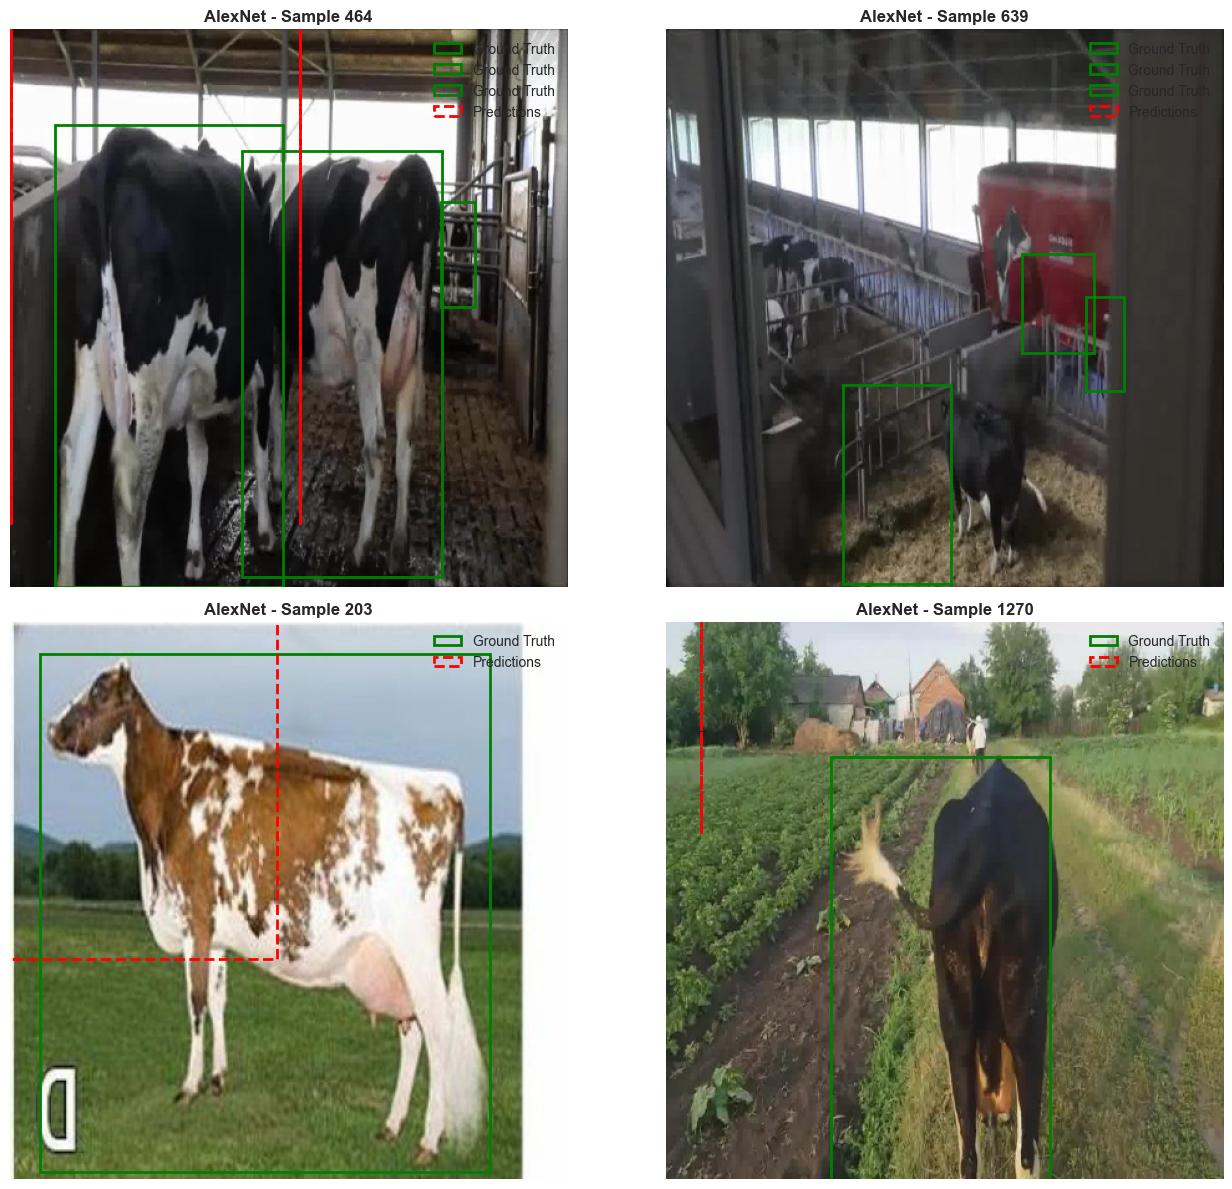

Saved: alexnet_predictions.png


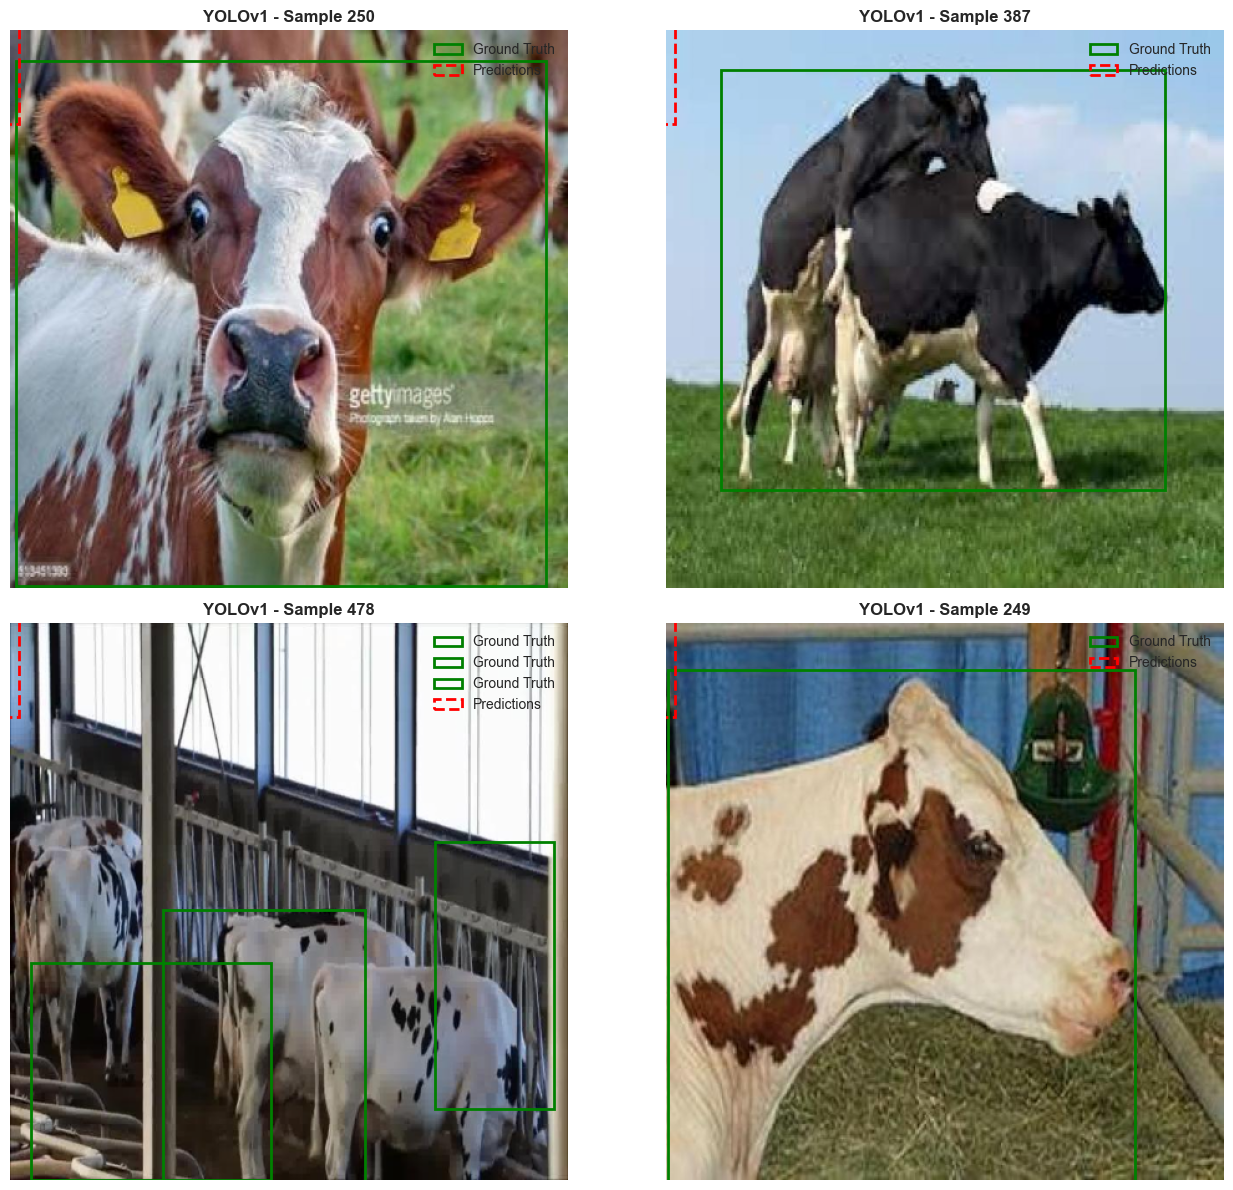

Saved: yolov1_predictions.png


In [33]:
def visualize_predictions(model, dataset, num_samples=4, confidence_threshold=0.3, model_name='Model'):
    """Visualize model predictions on random samples from dataset"""
    model.eval()
    
    # Select random indices
    indices = np.random.choice(len(dataset), size=min(num_samples, len(dataset)), replace=False)
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 12))
    axes = axes.flatten()
    
    with torch.no_grad():
        for plot_idx, sample_idx in enumerate(indices):
            if plot_idx >= 4:
                break
            
            image, target = dataset[sample_idx]
            image_input = image.unsqueeze(0).to(DEVICE)
            
            # Get predictions
            predictions = model(image_input)
            
            # Denormalize image for visualization
            image_np = image.permute(1, 2, 0).cpu().numpy()
            image_np = (image_np * np.array([0.229, 0.224, 0.225]) + 
                       np.array([0.485, 0.456, 0.406])).clip(0, 1)
            
            ax = axes[plot_idx]
            ax.imshow(image_np)
            ax.set_title(f'{model_name} - Sample {sample_idx}', fontweight='bold')
            
            # Draw ground truth boxes (green)
            for i in range(GRID_SIZE):
                for j in range(GRID_SIZE):
                    if target[i, j, 4] > 0.5:
                        x, y, w, h = target[i, j, :4].tolist()
                        x1 = (x - w/2) * image_np.shape[1]
                        y1 = (y - h/2) * image_np.shape[0]
                        x2 = (x + w/2) * image_np.shape[1]
                        y2 = (y + h/2) * image_np.shape[0]
                        rect = plt.Rectangle((x1, y1), x2-x1, y2-y1, fill=False, 
                                           edgecolor='green', linewidth=2, label='Ground Truth')
                        ax.add_patch(rect)
            
            # Draw predicted boxes (red)
            pred_drawn = False
            for i in range(GRID_SIZE):
                for j in range(GRID_SIZE):
                    conf = torch.sigmoid(predictions[0, i, j, 4]).item()
                    if conf > confidence_threshold:
                        x = torch.clamp(predictions[0, i, j, 0], 0, 1).item()
                        y = torch.clamp(predictions[0, i, j, 1], 0, 1).item()
                        w = torch.clamp(predictions[0, i, j, 2], 0, 1).item()
                        h = torch.clamp(predictions[0, i, j, 3], 0, 1).item()
                        
                        x1 = (x - w/2) * image_np.shape[1]
                        y1 = (y - h/2) * image_np.shape[0]
                        x2 = (x + w/2) * image_np.shape[1]
                        y2 = (y + h/2) * image_np.shape[0]
                        rect = plt.Rectangle((x1, y1), x2-x1, y2-y1, fill=False, 
                                           edgecolor='red', linewidth=2, linestyle='--')
                        ax.add_patch(rect)
                        if not pred_drawn:
                            rect.set_label('Predictions')
                            pred_drawn = True
            
            ax.legend(loc='upper right')
            ax.axis('off')
    
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, f'{model_name.lower()}_predictions.png'), dpi=100, bbox_inches='tight')
    plt.show()
    print(f"Saved: {model_name.lower()}_predictions.png")


# Visualize AlexNet predictions
visualize_predictions(alexnet, dataset, num_samples=4, confidence_threshold=0.3, model_name='AlexNet')

# Visualize YOLOv1 predictions
visualize_predictions(yolo, dataset, num_samples=4, confidence_threshold=0.3, model_name='YOLOv1')

In [34]:
def print_predictions(model, dataset, num_samples=4, confidence_threshold=0.3, model_name='Model'):
    """Print detailed predictions from model on random samples"""
    model.eval()
    
    # Select random indices
    indices = np.random.choice(len(dataset), size=min(num_samples, len(dataset)), replace=False)
    
    print("\n" + "="*80)
    print(f"{model_name} PREDICTIONS ON SAMPLES")
    print("="*80)
    
    with torch.no_grad():
        for sample_idx in indices:
            image, target = dataset[sample_idx]
            image_input = image.unsqueeze(0).to(DEVICE)
            predictions = model(image_input)
            
            print(f"\n{'─'*80}")
            print(f"Sample {sample_idx}")
            print(f"{'─'*80}")
            
            # Print ground truth
            print(f"\nGROUND TRUTH BOXES:")
            gt_count = 0
            for i in range(GRID_SIZE):
                for j in range(GRID_SIZE):
                    if target[i, j, 4] > 0.5:
                        gt_count += 1
                        x, y, w, h = target[i, j, :4].tolist()
                        cls_probs = target[i, j, NUM_BBOXES*5:]
                        cls = torch.argmax(cls_probs).item() if cls_probs.sum() > 0 else 0
                        print(f"  Box {gt_count}: Class={cls:2d} | Center=({x:.3f}, {y:.3f}) | Size=({w:.3f}, {h:.3f}) | Grid=({i}, {j})")
            
            if gt_count == 0:
                print("  (No ground truth boxes)")
            
            # Print predictions
            print(f"\nPREDICTED BOXES (confidence > {confidence_threshold}):")
            pred_count = 0
            predictions_list = []
            for i in range(GRID_SIZE):
                for j in range(GRID_SIZE):
                    conf = torch.sigmoid(predictions[0, i, j, 4]).item()
                    if conf > confidence_threshold:
                        x = torch.clamp(predictions[0, i, j, 0], 0, 1).item()
                        y = torch.clamp(predictions[0, i, j, 1], 0, 1).item()
                        w = torch.clamp(predictions[0, i, j, 2], 0, 1).item()
                        h = torch.clamp(predictions[0, i, j, 3], 0, 1).item()
                        cls_probs = torch.softmax(predictions[0, i, j, NUM_BBOXES*5:], dim=0)
                        cls = torch.argmax(cls_probs).item()
                        class_prob = cls_probs[cls].item()
                        
                        pred_count += 1
                        predictions_list.append((conf, cls, x, y, w, h, class_prob, i, j))
            
            # Sort by confidence
            predictions_list.sort(reverse=True, key=lambda x: x[0])
            
            for pred_count, (conf, cls, x, y, w, h, class_prob, i, j) in enumerate(predictions_list, 1):
                print(f"  Box {pred_count}: Class={cls:2d} (prob={class_prob:.3f}) | Confidence={conf:.3f} | Center=({x:.3f}, {y:.3f}) | Size=({w:.3f}, {h:.3f}) | Grid=({i}, {j})")
            
            if len(predictions_list) == 0:
                print(f"  (No predictions above threshold)")
            
            # Summary
            print(f"\nSUMMARY: {gt_count} ground truth boxes | {len(predictions_list)} predictions")


# Print AlexNet predictions
print_predictions(alexnet, dataset, num_samples=4, confidence_threshold=0.3, model_name='AlexNet')

# Print YOLOv1 predictions
print_predictions(yolo, dataset, num_samples=4, confidence_threshold=0.3, model_name='YOLOv1')


AlexNet PREDICTIONS ON SAMPLES

────────────────────────────────────────────────────────────────────────────────
Sample 464
────────────────────────────────────────────────────────────────────────────────

GROUND TRUTH BOXES:
  Box 1: Class= 0 | Center=(0.803, 0.403) | Size=(0.061, 0.189) | Grid=(2, 5)
  Box 2: Class= 0 | Center=(0.284, 0.585) | Size=(0.409, 0.830) | Grid=(4, 1)
  Box 3: Class= 0 | Center=(0.595, 0.599) | Size=(0.359, 0.766) | Grid=(4, 4)

PREDICTED BOXES (confidence > 0.3):
  Box 1: Class= 0 (prob=0.998) | Confidence=0.712 | Center=(0.000, 0.447) | Size=(0.063, 1.000) | Grid=(4, 3)
  Box 2: Class= 0 (prob=0.997) | Confidence=0.529 | Center=(0.411, 0.447) | Size=(0.000, 1.000) | Grid=(4, 4)
  Box 3: Class= 0 (prob=0.999) | Confidence=0.386 | Center=(0.000, 0.370) | Size=(0.000, 1.000) | Grid=(4, 2)
  Box 4: Class= 0 (prob=0.999) | Confidence=0.337 | Center=(1.000, 0.000) | Size=(0.000, 0.000) | Grid=(2, 5)
  Box 5: Class= 0 (prob=0.996) | Confidence=0.311 | Center=(1.